In [1]:
%cd /TransformerTTS

/TransformerTTS


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


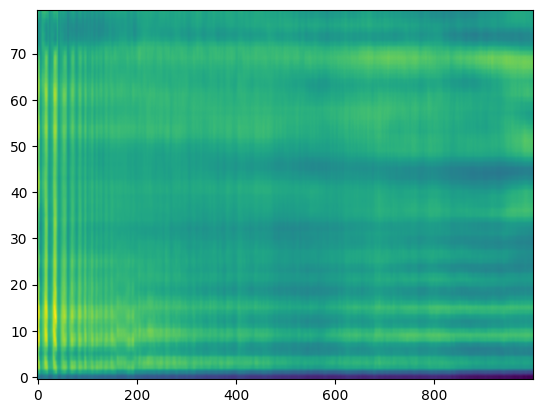

In [ ]:
import yaml
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt

from parallel_wavegan.utils import load_model
from model import TransformerTTS
from dataset import TransformerTTSDataset
from IPython.display import Audio
from utils.util import plot_mel, seed_everything

import warnings
warnings.filterwarnings('ignore')


with open("config/model_config.yml", "r") as f:
    m_config = yaml.safe_load(f)

with open("config/train_config.yml", "r") as f:
    t_config = yaml.safe_load(f)
seed_everything(t_config)

model = TransformerTTS(m_config)
ckpt = torch.load("out/ckpt/30000steps.ckpt", map_location="cuda:0")
ckpt["model"] = {key.replace("module.", ""): value for key, value in ckpt["model"].items()}
model.load_state_dict(ckpt["model"], strict=False)
model = model.cuda()

def text_to_sequence(text: str):
    with open("config/preprocess_config.yml", "r") as f:
        p_config = yaml.safe_load(f)

    text_preprocessor = TransformerTTSDataset(p_config).text_processor
    phoneme, src_len = text_preprocessor(text)
    return phoneme, src_len.long()

phoneme, src_len = text_to_sequence(["test", "Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition"])
phoneme = phoneme.cuda()
src_len = src_len.cuda()

model.eval()
mel_out, stop_token, mel_postnet = model.inference(phoneme, src_len)

mel = mel_out[1].detach().cpu().numpy()
plt.imshow(mel.T, aspect='auto', interpolation=None, origin='lower')
plt.show()

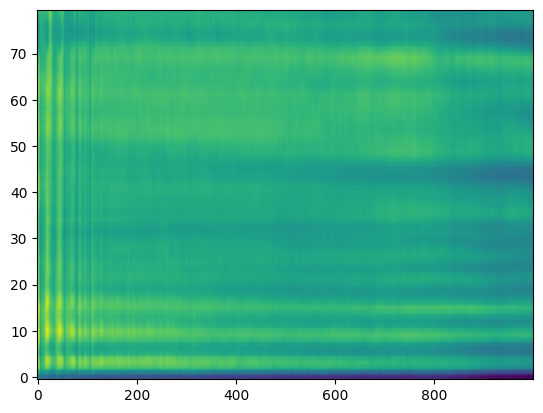

In [17]:
mel = mel_out[0].detach().cpu().numpy()
plt.imshow(mel.T, aspect='auto', interpolation=None, origin='lower')
plt.show()

In [ ]:
vocoder = load_model("/TransformerTTS/vocoder/checkpoint-2500000steps.pkl").to('cuda').eval()
vocoder.remove_weight_norm()
_ = vocoder.eval()

In [ ]:
y, sr = librosa.load("/TransformerTTS/data/wavs/LJ001-0001.wav")
S = np.abs(librosa.stft(y, n_fft=1024, hop_length=256)) ** 2

mel_filter = librosa.filters.mel(sr=sr, n_fft=1024, n_mels=80, fmin=80, fmax=7600)
mel = np.dot(mel_filter, S)

log_mel = librosa.power_to_db(mel)
# log_mel = np.log(np.clip(mel, 0.00001, None))
mu, sigma = np.mean(log_mel), np.std(log_mel)

normalized_log_mel = (log_mel - mu) / sigma

x = torch.FloatTensor(normalized_log_mel.T).cuda()
out = vocoder.inference(x).view(-1).detach().cpu().numpy()

Audio(out, rate=sr)

In [ ]:
plt.imshow(x.detach().cpu().numpy().T, aspect='auto', origin='lower')
plt.colorbar()
plt.show()

In [ ]:
mel_len = torch.LongTensor([2, 5, 3, 7])
stop_target = (torch.arange(10) >= mel_len[:, None]).float()
stop_target